In [1]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

In [24]:
# server = 'VT1'
# schema = 'SRSHNKDIG'

# server = 'MA3'
# schema = 'SRSANBDIG'

server = 'VT3'
schema = 'WCS01600'

features = queries.get_profit_ces_qty_by_day(server, schema)
features.describe().transpose()

count          mean           std            min           25%  \
TYEAR   1792.0  2.018059e+03  1.407257e+00    2016.000000  2.017000e+03   
TMON    1792.0  6.496094e+00  3.455546e+00       1.000000  3.750000e+00   
TDAY    1792.0  1.568694e+01  8.814592e+00       1.000000  8.000000e+00   
PROFIT  1792.0  4.741538e+07  4.016871e+07 -176659.540000  6.159041e+06   
CES     1792.0  2.683043e+06  2.273213e+06    -270.805556  3.440540e+05   
QTY     1792.0  2.405018e+06  2.042030e+06    -270.000000  3.151348e+05   

                 50%           75%           max  
TYEAR   2.018000e+03  2.019000e+03  2.021000e+03  
TMON    6.500000e+00  9.250000e+00  1.200000e+01  
TDAY    1.600000e+01  2.300000e+01  3.100000e+01  
PROFIT  4.681735e+07  8.527418e+07  1.334268e+08  
CES     2.681497e+06  4.742070e+06  1.107198e+07  
QTY     2.435069e+06  4.239085e+06  9.854548e+06

In [25]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

In [26]:
class schema_ML():
    def __init__(self, schema, df):
        
        # Store initial data.
        self.schema = schema
        self.df_initial = df
        
        self.models = {}
        self.model_params = Model_Params('mae', 'adam', 500, [], 2)
        
        self.train_performance = {}
        self.test_performance = {}
        self.mfe = {}
        self.mae = {}
        self.mse = {}
        self.rmse = {}
        
        # Preprocess data.
        self.preprocess()
        
    def preprocess(self):
        
        # Reference DF
        df = self.df_initial
        
        # Combine individual date columns to single index
        df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
        df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
        df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
        df.set_index('DATE', inplace=True)
        
        # Insert zeros for missing dates
        df = self.add_missing_dates(df)
        self.df = df
        df.plot(subplots=True, title='Initial Data') 
        
        # Add daily average columns
        # df = self.add_daily_averages(df)
        
        # Add differencing
        df = self.add_differencing(df)
        self.differenced_df = df
        df.plot(subplots=True, title='Added Differencing')
        
        # Normalize using scaler
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled = scaler.fit_transform(df.values)
        df = pd.DataFrame(scaled, columns=df.columns)
        df.plot(subplots=True, title='Added Normalization')
        self.normalized_df = df
        self.scaler = scaler
        
        # Split into train/val/test
        train_df, test_df = self.train_test_split(df)
        
        self.train_df = train_df
        self.test_df = test_df
        
    def add_missing_dates(self, df):
        missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
        n = len(missing_dates)
        m = len(df.columns)
        missing_dates_data = np.zeros((n,m))
        missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
        dfs = [df, missing_dates_df]
        df = pd.concat(dfs)
        df['Date'] = df.index
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        
        return df
    
    def add_daily_averages(self, df):
        indexes = df.index.to_numpy()
        data = df.to_numpy()
        columns = list(df)

        rows = data.shape[0]
        cols = data.shape[1]
        avgcol_names = []
        avgcols = []
        
        for y in range(0, cols):
            avgcol = np.zeros((rows,1))
            col = data[:,y]
            
            for d in range(0, 365):
                day_d_entries = col[d: len(col): 365]
                day_d_entries[day_d_entries == 0] = np.nan
                avg = np.nanmean(day_d_entries)
                avgcol[d: len(col): 365] = avg
                
            avgcols.append(avgcol)
            avgcol_names.append(columns[y] + '_DAY_AVG')
        
        for newcol in avgcols:
            data = np.concatenate((data, newcol), axis=1)
            
        df = pd.DataFrame(data, index=df.index, columns=columns + avgcol_names).fillna(0)
        return df
        
    def add_differencing(self, df):
        df = df.diff(7)
        
        return df.dropna()
        
    def train_test_split(self, df):
        n = len(df)
        pct_test = (np.log2(n/2) * 0.01)
        num_test = int(n * pct_test)
        num_train = n - num_test
        
        train = df[:num_train]
        test = df[num_train:]
        
        return train, test
    
    def add_lag(self, df):
        lags = [1, 7, 14]
        cols = df.columns
        
        lagged = df.assign(**{
            '{} (t-{})'.format(col, t): df[col].shift(t)
            for t in lags
            for col in cols
        })
        
        return lagged.dropna()
    
    def reshape(self, X):
        X = X.values.reshape((X.shape[0], 1, X.shape[1]))
        
        return X
    
    def get_train_and_test(self, pred_col):
        train = self.train_df
        test = self.test_df

        train = self.add_lag(train)
        test = self.add_lag(test)

        X_train = train.filter(regex='^(?!' + pred_col + '$)')
        Y_train = train.filter(regex='^(' + pred_col + '$)')
        X_test = test.filter(regex='^(?!' + pred_col + '$)')
        Y_test = test.filter(regex='^(' + pred_col + '$)')
    
        X_train, X_test = self.reshape(X_train), self.reshape(X_test)
        
        return X_train, Y_train, X_test, Y_test
        
    def evaluate_and_plot(self, pred_col='PROFIT', model_name='', model=None, model_params=None):
        
        if model is not None:
        
            # Add model to dictionary
            if model_params == None:
                model_params = self.model_params

            if model is not None:
                self.models[model_name] = Models(model, model_params)

            # Get training and validation data
            X_train, Y_train, X_test, Y_test = self.get_train_and_test(pred_col)

            # Compile model    
            model.compile(loss=model_params.LOSS, optimizer=model_params.OPTIMIZER)
            
            # Fit model to training data
            history = model.fit(X_train, Y_train, epochs=model_params.EPOCHS, 
                                callbacks=model_params.CALLBACKS, validation_data=(X_test, Y_test),
                                verbose=model_params.VERBOSE, shuffle=False)

            # Add validation information to dictionary
            self.train_performance[model_name] = min(history.history['loss'])
            self.test_performance[model_name] = min(history.history['val_loss'])
            
            # Plot train vs. val losses
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='val')
            plt.title('Training Loss vs. Test Loss')
            plt.xlabel('# of Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
            # Calculate performance metrics and add to dictionaries
            expected = Y_test.values
            predicted = model(X_test)
            forecast_errors = [expected[i] - predicted[i] for i in range(len(expected))]
            
            mfe = np.mean(forecast_errors)
            mae = mean_absolute_error(expected, predicted)
            mse = mean_squared_error(expected, predicted)
            rmse = np.sqrt(mse)
            
            self.mfe[model_name] = mfe
            self.mae[model_name] = mae
            self.mse[model_name] = mse
            self.rmse[model_name] = rmse
            
            # Plot expected vs predicted
            plt.figure(figsize=(40,8))
            diff = self.test_df.index.shape[0] - expected.shape[0]
            plt.plot(self.test_df.index[diff:], expected, label='Expected', marker='.', zorder=-10)
            plt.scatter(self.test_df.index[diff:], predicted, label='Predicted', edgecolors='k', c='#2ca02c', s=64)
            plt.show()
            
            ### TEST - Inverse transform scaler ###
            
#             scaler = self.scaler
#             df_one = self.train_df
#             df_three = self.test_df
#             expected_df = pd.DataFrame(expected, index=Y_test.index, columns=Y_test.columns)
#             predicted_df = pd.DataFrame(predicted.numpy(), index=Y_test.index, columns=Y_test.columns)
            
#             expected_frames = [df_one[['PROFIT', 'CES']], expected_df, df_three[['PROFIT', 'CES']]]
#             predicted_frames = [df_one[['PROFIT', 'CES']], predicted_df, df_three[['PROFIT', 'CES']]]
#             full_expected_df = pd.concat(expected_frames)
#             full_predicted_df = pd.concat(predicted_frames)
            
#             inverse_expected = scaler.inverse_transform(full_expected_df)
#             inverse_predicted = scaler.inverse_transform(full_predicted_df)
            
#             indexes = df_one.index.union(expected_df.index).union(df_three.index)      
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=indexes)
#             print(inverse_expected_df)
            
            
#             inverse_expected_df = pd.DataFrame(inverse_expected, index=self.df_initial.index, columns=['PROFIT', 'CES'])
#             inverse_predicted_df = pd.DataFrame(inverse_predicted, index=self.df_initial.index, columns=['PROFIT', 'CES'])
            
            ### END TEST ###
            
            
        # Plot specified columns and results
        
        
    def performance_metrics(self):
        
        # Convert dictionarites to single dataframe
        mfe_df = pd.DataFrame.from_dict(self.mfe, columns=['MFE'], orient='index')
        mae_df = pd.DataFrame.from_dict(self.mae, columns=['MAE'], orient='index')
        mse_df = pd.DataFrame.from_dict(self.mse, columns=['MSE'], orient='index')
        rmse_df = pd.DataFrame.from_dict(self.rmse, columns=['RMSE'], orient='index')
        performance_df = mfe_df.join(mae_df).join(mse_df).join(rmse_df)
        performance_df = performance_df.transpose()
        
        performance_df.plot(kind='bar')
        plt.show()
        print(performance_df)

        

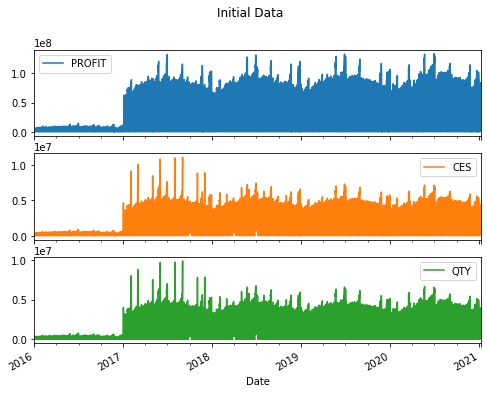

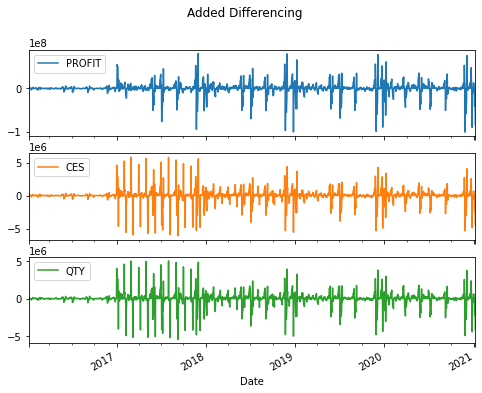

In [27]:
obj = schema_ML(schema, features)

Epoch 1/500
52/52 - 3s - loss: 0.0851 - val_loss: 0.0622
Epoch 2/500
52/52 - 0s - loss: 0.0491 - val_loss: 0.0464
Epoch 3/500
52/52 - 0s - loss: 0.0394 - val_loss: 0.0329
Epoch 4/500
52/52 - 0s - loss: 0.0294 - val_loss: 0.0191
Epoch 5/500
52/52 - 0s - loss: 0.0258 - val_loss: 0.0115
Epoch 6/500
52/52 - 0s - loss: 0.0249 - val_loss: 0.0091
Epoch 7/500
52/52 - 0s - loss: 0.0234 - val_loss: 0.0078
Epoch 8/500
52/52 - 0s - loss: 0.0227 - val_loss: 0.0074
Epoch 9/500
52/52 - 0s - loss: 0.0218 - val_loss: 0.0064
Epoch 10/500
52/52 - 0s - loss: 0.0214 - val_loss: 0.0063
Epoch 11/500
52/52 - 0s - loss: 0.0212 - val_loss: 0.0064
Epoch 12/500
52/52 - 0s - loss: 0.0207 - val_loss: 0.0060
Epoch 13/500
52/52 - 0s - loss: 0.0207 - val_loss: 0.0061
Epoch 14/500
52/52 - 0s - loss: 0.0202 - val_loss: 0.0059
Epoch 15/500
52/52 - 0s - loss: 0.0199 - val_loss: 0.0061
Epoch 16/500
52/52 - 0s - loss: 0.0196 - val_loss: 0.0066
Epoch 17/500
52/52 - 0s - loss: 0.0193 - val_loss: 0.0064
Epoch 18/500
52/52 - 0s

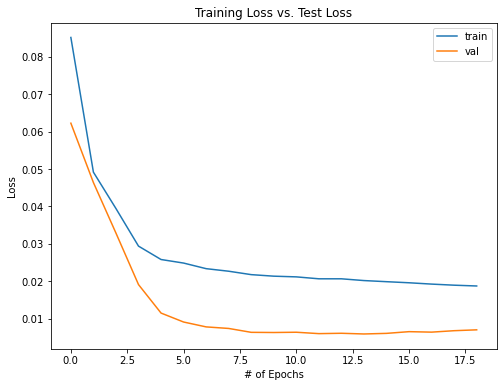

In [28]:
MONITOR = 'val_loss'
PATIENCE = 5
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'Base LSTM'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
51/51 - 5s - loss: 0.0808 - val_loss: 0.0549
Epoch 2/500
51/51 - 0s - loss: 0.0318 - val_loss: 0.0218
Epoch 3/500
51/51 - 0s - loss: 0.0193 - val_loss: 0.0163
Epoch 4/500
51/51 - 0s - loss: 0.0179 - val_loss: 0.0164
Epoch 5/500
51/51 - 0s - loss: 0.0179 - val_loss: 0.0148
Epoch 6/500
51/51 - 0s - loss: 0.0176 - val_loss: 0.0147
Epoch 7/500
51/51 - 0s - loss: 0.0174 - val_loss: 0.0155
Epoch 8/500
51/51 - 0s - loss: 0.0170 - val_loss: 0.0140
Epoch 9/500
51/51 - 0s - loss: 0.0174 - val_loss: 0.0167
Epoch 10/500
51/51 - 0s - loss: 0.0173 - val_loss: 0.0161
Epoch 11/500
51/51 - 0s - loss: 0.0168 - val_loss: 0.0138
Epoch 12/500
51/51 - 0s - loss: 0.0163 - val_loss: 0.0140
Epoch 13/500
51/51 - 0s - loss: 0.0167 - val_loss: 0.0156
Epoch 14/500
51/51 - 0s - loss: 0.0166 - val_loss: 0.0140
Epoch 15/500
51/51 - 0s - loss: 0.0164 - val_loss: 0.0138
Epoch 16/500
51/51 - 0s - loss: 0.0169 - val_loss: 0.0144
Epoch 17/500
51/51 - 0s - loss: 0.0164 - val_loss: 0.0141
Epoch 18/500
51/51 - 0s

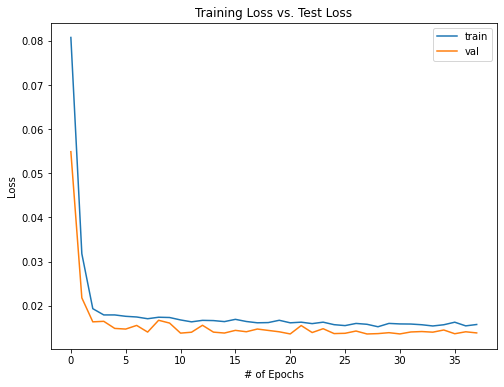

In [7]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_1'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


In [8]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_2'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)


Epoch 1/500
51/51 - 5s - loss: 0.0805 - val_loss: 0.0523
Epoch 2/500
51/51 - 0s - loss: 0.0324 - val_loss: 0.0189
Epoch 3/500
51/51 - 0s - loss: 0.0231 - val_loss: 0.0151
Epoch 4/500
51/51 - 0s - loss: 0.0213 - val_loss: 0.0146
Epoch 5/500
51/51 - 0s - loss: 0.0208 - val_loss: 0.0148
Epoch 6/500
51/51 - 0s - loss: 0.0194 - val_loss: 0.0147
Epoch 7/500
51/51 - 0s - loss: 0.0195 - val_loss: 0.0138
Epoch 8/500
51/51 - 0s - loss: 0.0196 - val_loss: 0.0143
Epoch 9/500
51/51 - 0s - loss: 0.0193 - val_loss: 0.0141
Epoch 10/500
51/51 - 0s - loss: 0.0199 - val_loss: 0.0162
Epoch 11/500
51/51 - 0s - loss: 0.0190 - val_loss: 0.0140
Epoch 12/500
51/51 - 0s - loss: 0.0195 - val_loss: 0.0160
Epoch 13/500
51/51 - 0s - loss: 0.0183 - val_loss: 0.0132
Epoch 14/500
51/51 - 0s - loss: 0.0187 - val_loss: 0.0146
Epoch 15/500
51/51 - 0s - loss: 0.0181 - val_loss: 0.0152
Epoch 16/500
51/51 - 0s - loss: 0.0182 - val_loss: 0.0145
Epoch 17/500
51/51 - 0s - loss: 0.0179 - val_loss: 0.0146
Epoch 18/500
51/51 - 0s

Epoch 1/500
51/51 - 5s - loss: 0.0816 - val_loss: 0.0536
Epoch 2/500
51/51 - 0s - loss: 0.0345 - val_loss: 0.0191
Epoch 3/500
51/51 - 0s - loss: 0.0239 - val_loss: 0.0162
Epoch 4/500
51/51 - 0s - loss: 0.0233 - val_loss: 0.0141
Epoch 5/500
51/51 - 0s - loss: 0.0228 - val_loss: 0.0152
Epoch 6/500
51/51 - 0s - loss: 0.0221 - val_loss: 0.0165
Epoch 7/500
51/51 - 0s - loss: 0.0221 - val_loss: 0.0143
Epoch 8/500
51/51 - 0s - loss: 0.0223 - val_loss: 0.0143
Epoch 9/500
51/51 - 0s - loss: 0.0215 - val_loss: 0.0143
Epoch 10/500
51/51 - 0s - loss: 0.0216 - val_loss: 0.0148
Epoch 11/500
51/51 - 0s - loss: 0.0209 - val_loss: 0.0147
Epoch 12/500
51/51 - 0s - loss: 0.0204 - val_loss: 0.0140
Epoch 13/500
51/51 - 0s - loss: 0.0201 - val_loss: 0.0148
Epoch 14/500
51/51 - 0s - loss: 0.0203 - val_loss: 0.0147
Epoch 15/500
51/51 - 0s - loss: 0.0202 - val_loss: 0.0156
Epoch 16/500
51/51 - 0s - loss: 0.0199 - val_loss: 0.0148
Epoch 17/500
51/51 - 0s - loss: 0.0187 - val_loss: 0.0138
Epoch 18/500
51/51 - 0s

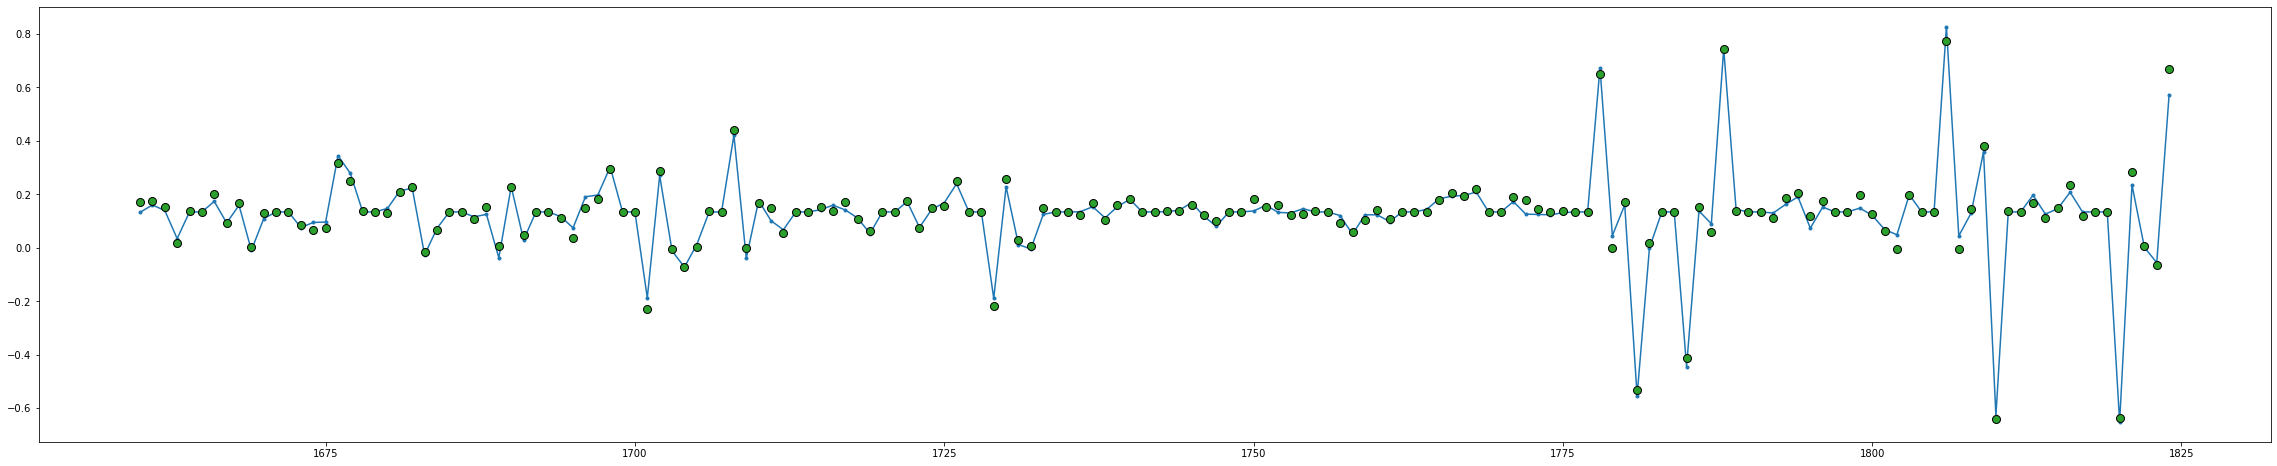

In [9]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_3'
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)

In [10]:
obj.performance_metrics()

      Base LSTM    LSTM_1    LSTM_2    LSTM_3
MFE   -0.001664 -0.001279 -0.001272 -0.002652
MAE    0.013136  0.013580  0.013212  0.013780
MSE    0.000388  0.000454  0.000390  0.000424
RMSE   0.019708  0.021313  0.019750  0.020587


Epoch 1/500
51/51 - 2s - loss: 0.0853 - val_loss: 0.0711
Epoch 2/500
51/51 - 0s - loss: 0.0545 - val_loss: 0.0503
Epoch 3/500
51/51 - 0s - loss: 0.0329 - val_loss: 0.0227
Epoch 4/500
51/51 - 0s - loss: 0.0216 - val_loss: 0.0170
Epoch 5/500
51/51 - 0s - loss: 0.0179 - val_loss: 0.0163
Epoch 6/500
51/51 - 0s - loss: 0.0170 - val_loss: 0.0146
Epoch 7/500
51/51 - 0s - loss: 0.0168 - val_loss: 0.0151
Epoch 8/500
51/51 - 0s - loss: 0.0171 - val_loss: 0.0150
Epoch 9/500
51/51 - 0s - loss: 0.0163 - val_loss: 0.0141
Epoch 10/500
51/51 - 0s - loss: 0.0163 - val_loss: 0.0147
Epoch 11/500
51/51 - 0s - loss: 0.0163 - val_loss: 0.0147
Epoch 12/500
51/51 - 0s - loss: 0.0166 - val_loss: 0.0142
Epoch 13/500
51/51 - 0s - loss: 0.0162 - val_loss: 0.0142
Epoch 14/500
51/51 - 0s - loss: 0.0162 - val_loss: 0.0140
Epoch 15/500
51/51 - 0s - loss: 0.0158 - val_loss: 0.0145
Epoch 16/500
51/51 - 0s - loss: 0.0157 - val_loss: 0.0138
Epoch 17/500
51/51 - 0s - loss: 0.0161 - val_loss: 0.0143
Epoch 18/500
51/51 - 0s

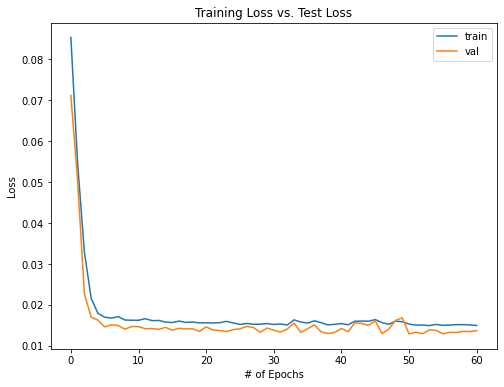

In [21]:
MONITOR = 'val_loss'
PATIENCE = 10
RESTORE_BEST_WEIGHTS = True
ES = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE, 
                                    restore_best_weights=RESTORE_BEST_WEIGHTS)

LOSS = 'mae'
OPTIMIZER = 'adam'
EPOCHS = 500
CALLBACKS = [ES]
VERBOSE = 2

model_params = Model_Params(LOSS, OPTIMIZER, EPOCHS, CALLBACKS, VERBOSE)
model_name = 'LSTM_3'
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(16, return_sequences=True),
    tf.keras.layers.GRU(16),
    tf.keras.layers.Dense(1)
])

obj.evaluate_and_plot(model_name=model_name, model=model, model_params=model_params)